In [1]:
import logging
from typing import List, Callable, Optional, Any

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.decomposition import PCA


from pynamics import downsample, downsample_split, avg_over, get_attractor_dimension
from pynamics.utils import np_cache, eigsort

from randnn import SparseRandNN, scaling_analysis
from hoogland_masters.plotting import *

rc('text', usetex=True)
logging.basicConfig(level=logging.ERROR)

## The model
$$\tau \frac{dh_i}{dt}=-h_i+\sum_{j=1}^N J_{ij}\phi(h_j),$$

#### "Fixed" Parameters
- $\tau$ is the characteristic timescale ($:=1$).
- $h_i$ is the activation of neuron $i$.
- $J_{ij}\sim \mathcal N(0, g^2/N)$ is the coupling matrix.
- $\phi$ is the activation function ($=\tanh$).

####  "Loose" Parameters
- $N$ is the number of neurons.
- $g$ is the coupling strength.
- $k$ is the (average) degree of the nodes
    - For the dense network, $k_0\equiv k_\text{dense}=N-1$ (no self-connections)
    - For the sparse network, $k_S= (N-1) \cdot (1-S)$, where
- $S$ is the sparsity coefficient (i.e., the fraction of edges to dilute to zero).


## How to compare sparse networks to dense networks?
1. **Vary $S$. Constant $g$ and $N$**: This is the naive option. The problem is that the average neuron will see have less input. Just like a network with a lower $g$  
2. **Vary $S$ and $g$. Constant $N$**:
    - $g':\quad g\cdot k_0 = g' \cdot k_S = \text{cst.}$ 
    - Here the problem is that $\phi$ is non-linear, so although the "average connective strength" is constant, the dynamic rule is changed. This might work better with threshold units (esp. linear ones)
3. **Vary $S$ and $N$. Constant $g$:** 
    - $N': \quad g\cdot k_0(N) = g \cdot k_S(N') = \text{cst.},$
    - where $k_S(N) = (N-1)\cdot (1-S)$
    - The average connection strength is the same per node & we're in the same range for $\phi$, but the network is of a different size.  
    - One problem is that the network size grows rapidly as $S\to 0$. This favors the other options.


Option 2 seems best (though I'll try all of the above). It's the same idea that Engelken et al. use to compare networks of different sizes.


In [2]:
# Shared parameters
N_STEPS = 100000
N_DOFS = 200

TIMESTEP = 0.1
N_BURNIN_STEPS = 500
DOWNSAMPLE_RATE = 100

In [3]:
rc('text', usetex=False)

def get_lyapunov_spectrum(trajectory, system):
    n_dofs = trajectory.shape[1]
    # plt.plot(trajectory[:1000, :5])
    # plt.show()
    return np.arange(n_dofs)/n_dofs, np.sort(system.get_lyapunov_spectrum(trajectory, t_ons=100))[::-1]

def measure_over_range(
        param_range: List[dict],
        observable: Callable[[np.ndarray, SparseRandNN], np.ndarray],
        n_steps: int = 10000,
        n_burn_in: int = 1000,
    **kwargs
):
    """
    A helper function for plotting vector measurements across ranges of
    coupling strength values. Each measurement will be plotted as a single curve.
:param observable: A function which takes a generated trajectory and
        the Trajectory object that generated it, and computes a
        measurement on it.
    :param n_dofs: The number of elements (neurons).
    :param n_steps: How many timesteps to simulate for each
        coupling_strength.
    :param n_burn_in: How many burnin timesteps to simulate before
        starting to record.
    :param kwargs:
    """
    results = []
    
    for i, params in enumerate(param_range):
        
        # 1. Initialize a network
        cont_nn = SparseRandNN(**params,
                               network_seed=12345,
                               **kwargs)

        # 2. Simulate a phase space trajectory
        trajectory = cont_nn.run(n_steps=n_steps, n_burn_in=n_burn_in)[::DOWNSAMPLE_RATE]

        # 3. Perform your measurement
        measurement_range, measurement = observable(trajectory, cont_nn)

        label = ", ".join(list(map(lambda vals: f"{vals[0]} {vals[1]}", params.items())))
        results.append([measurement_range, measurement, f"{i}. {label}"])

    return results


def plot_lyap_spec_over_range(params_range, **kwargs):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    results = measure_over_range(params_range, get_lyapunov_spectrum, **kwargs)

    for [x, y, label] in results:
        ax.plot(x, y, label=label)

    plt.axhline(y=0., linestyle="--")

    del results

    ax.set_title(f"$g={kwargs['coupling_strength']}$")
    ax.set_ylabel("$\lambda_i$")
    ax.set_xlabel("$i/N$")
    ax.legend()
    

def plot_lyap_spec_over_double_range(outside_range, inside_range, **kwargs):
    for outside_params in outside_range:
        plot_lyap_spec_over_range(inside_range, **outside_params, **kwargs)
        plt.show()
    

## Shared parameters

In [4]:
SPARSITIES = [0., 0.5, 0.9] #, 0.95, 0.99]
SPARSITIES_RANGE = list(map(lambda s: {"sparsity": s}, SPARSITIES))
GS_RANGE = list(map(lambda g: { "coupling_strength": g}, [3., 10.])) # 5., 20.])) #, 20.]))

## 1. Vary $S$, constant $g$ & $N$

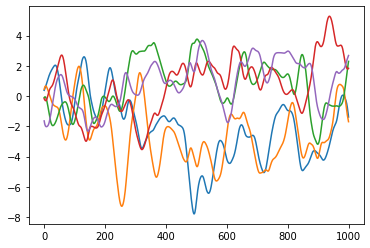

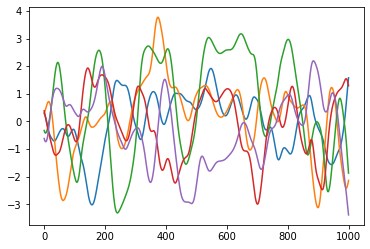

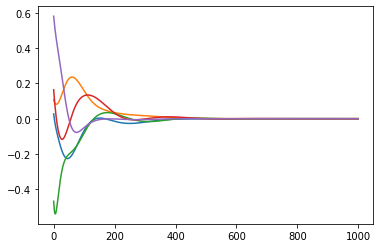

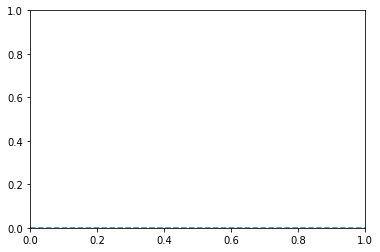

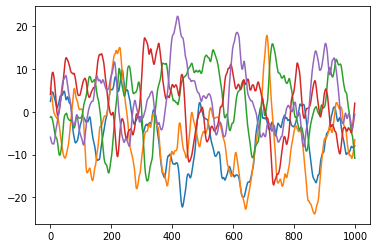

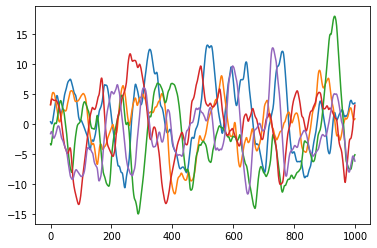

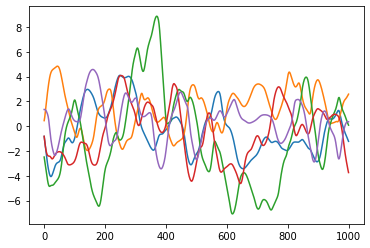

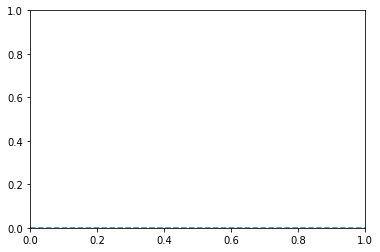

In [5]:
plot_lyap_spec_over_double_range(GS_RANGE, SPARSITIES_RANGE, n_dofs=N_DOFS, n_steps=N_STEPS, normalize_strength=False)

## 2. Vary $S$ & $g$, constant $g\cdot k$ & $N$

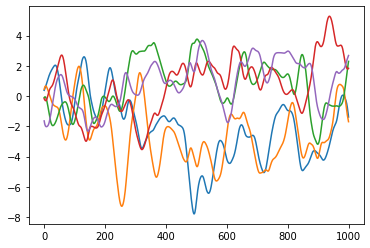

Generating samples:   4%|▍         | 4187/100000 [00:01<00:23, 4013.66it/s]


KeyboardInterrupt: 

In [6]:
plot_lyap_spec_over_double_range(GS_RANGE, SPARSITIES_RANGE, n_dofs=N_DOFS, n_steps=N_STEPS, normalize_strength=True)


## 3. Vary $S$ & $N$, constant $k$

In [ ]:
# We only go up to $S=0.95$ (which is 20 times as much as the initial DOFS)
N_INIT_DOFS = 100
SN_RANGE = map(lambda s: {"sparsity": s, "n_dofs": int(1 + ((N_INIT_DOFS-1)/(1-s)))}, SPARSITIES[:-2]) 

plot_lyap_spec_over_double_range(GS_RANGE, SPARSITIES_RANGE, n_steps=N_STEPS, normalize_strength=False)


## Appendix

Other things to do:

In [ ]:
# Compare exact same network architectures and relative weights, vary only absolute coupling strength.